# Clickabit detection using informativeness measures

## Packages

In [ ]:
import warnings
import unicodedata
import string 

import numpy as np
import pandas as pd
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
import textstat
from lexical_diversity import lex_div

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

import math
import re
from tqdm import tqdm

from textblob import TextBlob
from gensim.models import Word2Vec
from scipy.spatial.distance import cosine

from tabulate import tabulate
from statsmodels.stats.weightstats import ttest_ind

In [2]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to /home/tymek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
MODEL = Word2Vec.load("../pretrained_models/custom_word2vec.model")
STOP_WORDS = stopwords.words("english")

In [ ]:
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

[nltk_data] Downloading package punkt_tab to /home/tymek/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/tymek/nltk_data...


[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

## Preprocessing

In [3]:
raw_data = pd.read_csv("../data/cc_dataset_balanced.csv")

In [21]:
# drop NA
raw_data = raw_data.drop(raw_data[raw_data['body'].isna()].index)
full_data = raw_data.copy()

In [161]:
# clean escape characters
full_data['body'] = full_data['body'].apply(lambda x: unicodedata.normalize('NFKC', x))
full_data['title'] = full_data['title'].apply(lambda x: unicodedata.normalize('NFKC', x))

In [162]:
data, test_data = train_test_split(full_data, test_size=0.2, random_state=42)

## EDA

In [163]:
eda_df = data.copy()

### Punctuation

In [164]:
def count_punkt(text, punkt):
    return sum([1 for char in text if char == punkt])

for punkt in string.punctuation:
    eda_df[f'{punkt}_count'] = eda_df['title'].apply(lambda x: count_punkt(x, punkt))

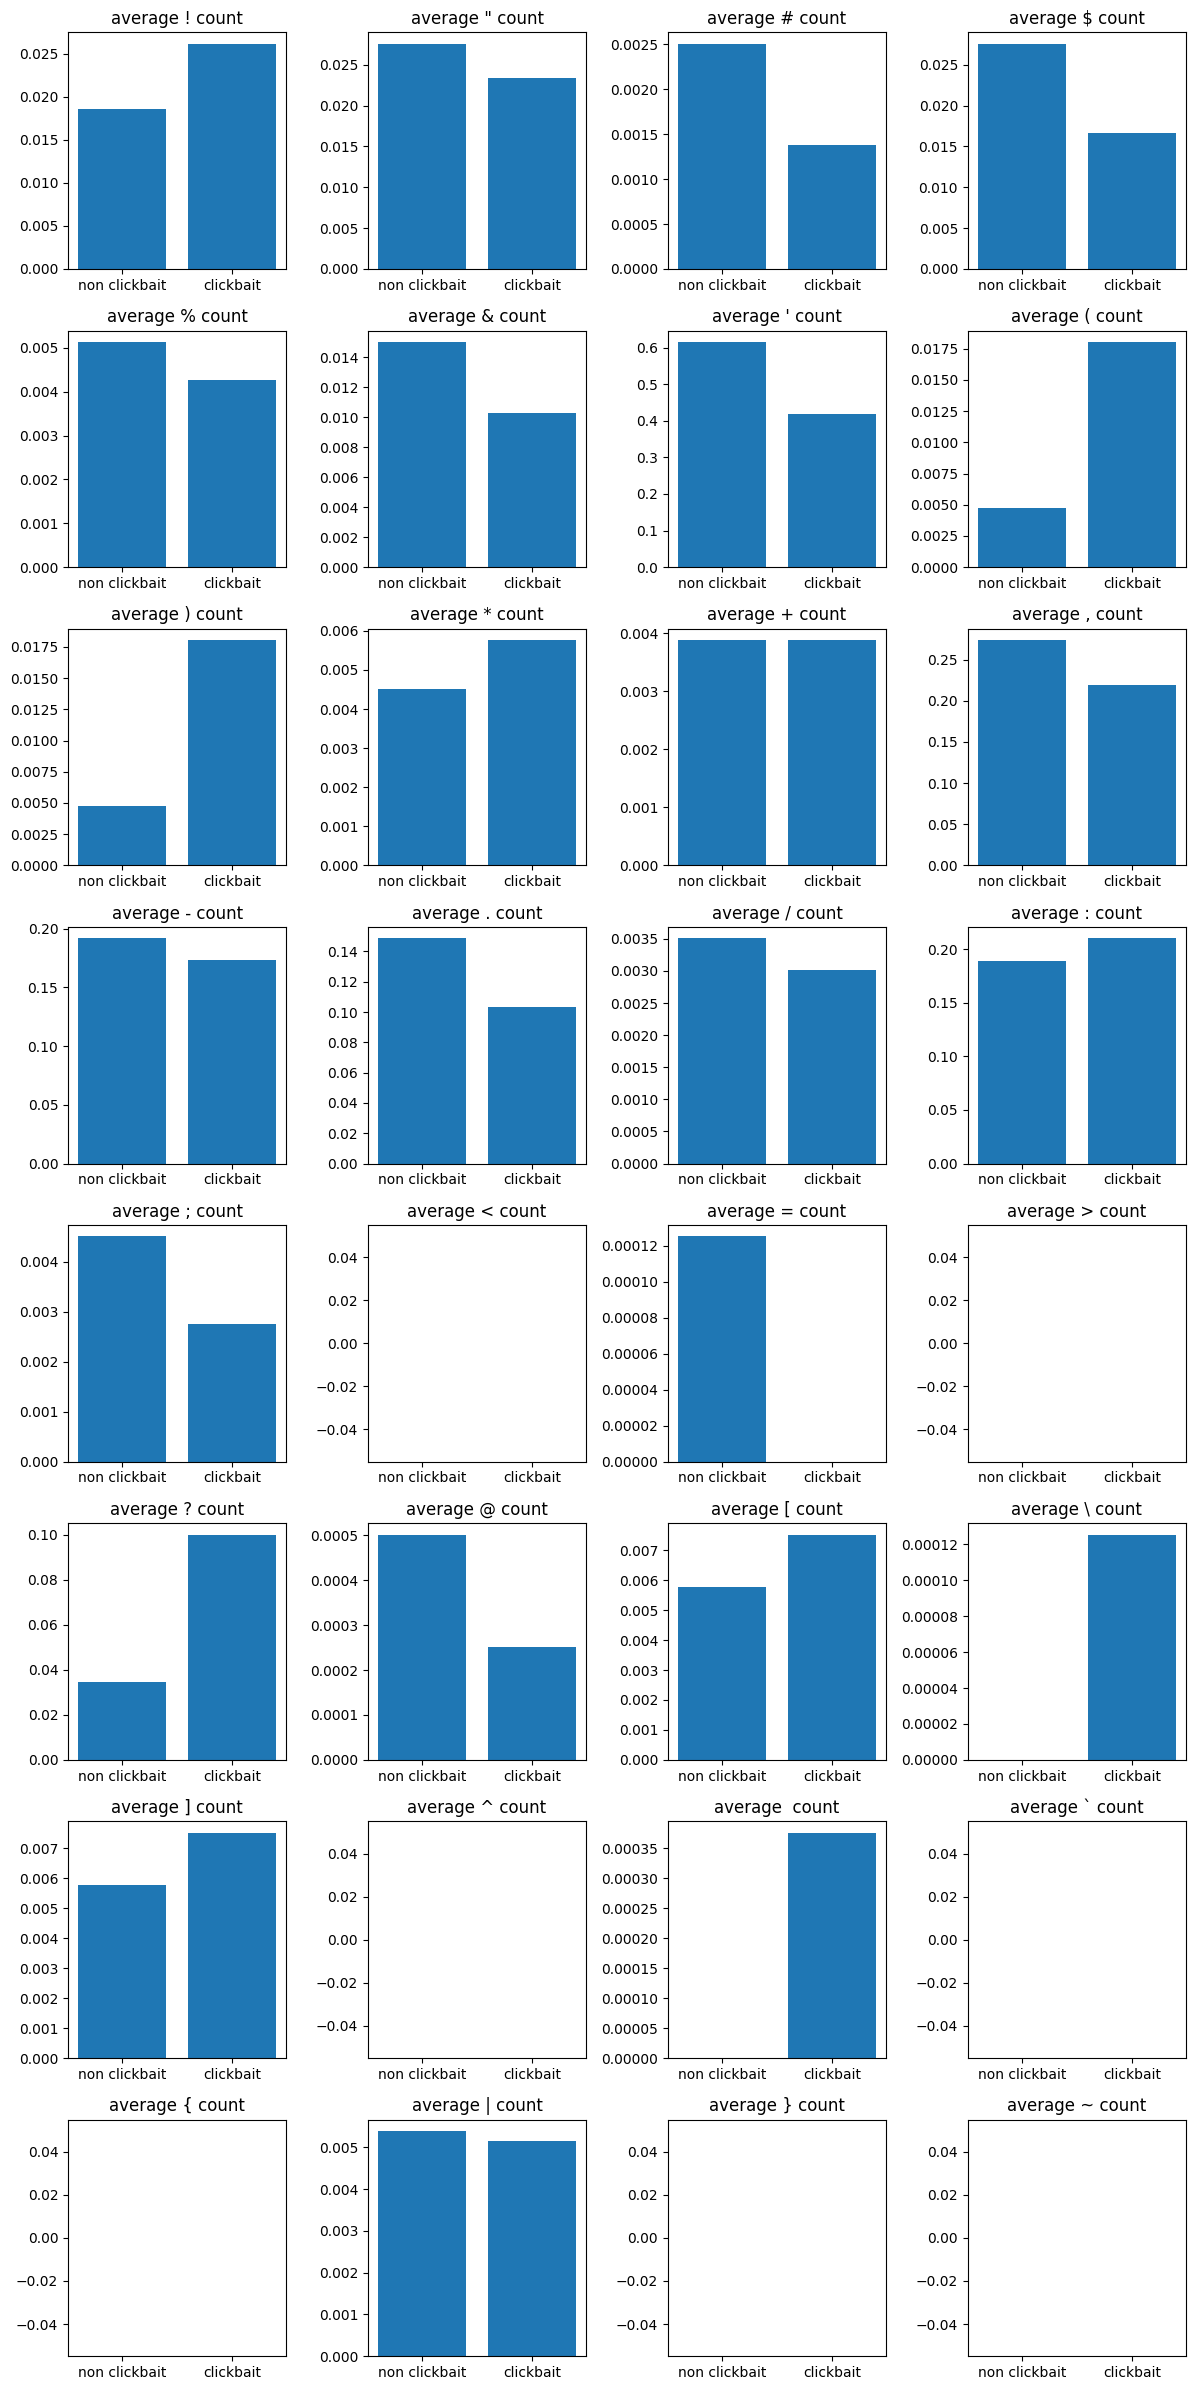

In [165]:
plt.figure(figsize=(12,24))
columns = eda_df.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(8, 4, i+1)
    n_mean = eda_df[eda_df['clickbait'] == 0][col].mean()
    c_mean = eda_df[eda_df['clickbait'] == 1][col].mean()
    plt.bar(['non clickbait', 'clickbait'], height=[n_mean, c_mean])
    plt.title(f"average {col.split('_')[0]} {col.split('_')[-1]}")
plt.tight_layout()
plt.show()

Based on those features we plan to build two measures - clickbait punctuation and non clickbait punctuation. We are taking into account only punctuation with average count over 0.001. <br>
<br>
clickbaits: !()*?[] <br>
non clickbaits: #$&';

### sth

## Embedding model

Training model for word embedding for similarity scores

In [ ]:
def preprocess_text(text):
    """ preprocess data for embedding model training """
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

In [ ]:
df = data.copy()

In [ ]:
df['body_len'] = df['body'].apply(lambda x: len(x))
th = np.percentile(df['body_len'], 90)
df = df[df['body_len'] < th]

In [ ]:
df["title_tokens"] = df["title"].apply(preprocess_text)
df["body_tokens"] = df["body"].apply(preprocess_text)
df["combined_tokens"] = df["title_tokens"] + df["body_tokens"]
sentences = df["combined_tokens"].tolist()

In [ ]:
model = Word2Vec(sentences, vector_size=100, min_count=1, workers=4)

In [ ]:
model.save("../pretrained_models/custom_word2vec.model")

## Metrics definition

Defining informativeness measures

In [51]:
""" helper functions """

def remove_punctuation(text):
    """ removes punctuation """
    return text.translate(str.maketrans('', '', string.punctuation))

def preprocess_text(text):
    """ preprocess data for embedding model training """
    if isinstance(text, list):
        text = ' '.join(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in STOP_WORDS]
    return tokens

def get_embedding(sentence):
    """ gets embeddings """
    word_embeddings = [MODEL.wv[word] for word in sentence if word in MODEL.wv]
    if not word_embeddings: 
        return np.zeros(MODEL.vector_size)
    sentence_embedding = np.mean(word_embeddings, axis=0)
    return sentence_embedding

In [69]:
def words_count(text):
    """ calculates number of words """
    return len(text.split())

def characters_count(text):
    """ calculates number of characters including whitespaces """
    return len(text.strip())

def avg_word_length(text):
    """ calculates average word length """
    return float(np.mean([len(word) for word in word_tokenize(remove_punctuation(text))]))

def common_words_ratio(text):
    """ percentage of stop words in text """
    words = word_tokenize(remove_punctuation(text.lower()))
    common_words = [word for word in words if word in STOP_WORDS]
    return len(common_words) / len(words)

def capital_letters_ratio(text):
    """ callculates capital letters ratio """
    return sum([char.isupper() for char in list(text)]) / len(text)

def capital_words_count(text):
    """ calculates capital words """
    return sum([word.isupper() for word in word_tokenize(text)])

def punctuation_ratio(text):
    """ calculates punctuation ratio """
    return sum([1 for x in text if x in string.punctuation]) / len(text)

def clickbait_punctuation_count(text):
    """ counts clickbait related punctuation, only left brackets as otherwise they would be double calculated """
    uncommon_punctuation = "!(*?["
    return sum([1 for x in text if x in uncommon_punctuation])

def nonclickbait_punctuation_count(text):
    """ counts non-clickbait related punctuation """
    uncommon_punctuation = "#$&';"
    return sum([1 for x in text if x in uncommon_punctuation])

def numbers_count(text):
    """ calculates ratio of numbers (not digits) to words """
    text = remove_punctuation(text)
    return sum([x.isnumeric() for x in word_tokenize(text)])

def pronouns_count(text):
    """ pronouns usage """
    tagged = pos_tag(word_tokenize(text.lower()))
    return sum([1 for x in tagged if x[1] in ('PRP', 'PRP$', 'WP', 'WP$')])

def pronouns_2nd_person_count(text):
    """ 2nd person pronouns usage """
    second_person_pronouns = ["you", "your", "yours", "yourself", "yourselves"]
    return sum([1 for x in word_tokenize(text.lower()) if x in second_person_pronouns])

def superlatives_ratio(text):
    """ percentage of adjectives and adverbs which are in superlative form """
    tagged_words = pos_tag(word_tokenize(text.lower()))
    adj_adv_count = 0
    superlative_count = 0
    for _, tag in tagged_words:
        if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'):
            adj_adv_count += 1
            if tag in ('JJS', 'RBS'):  # if superlative
                superlative_count += 1
    if adj_adv_count == 0:
        return 0
    return superlative_count / adj_adv_count

def speculatives_count(text):
    """ usage of speculative forms """
    speculative_words = {
        "might", "may", "could", "can", "perhaps", "possibly", "probably", "maybe",
        "seems", "appears", "suggests", "indicates", "likely", "unlikely", "assume", "will"
    }
    return sum([1 for x in word_tokenize(text.lower()) if x in speculative_words])

def baiting_words_count(text):
    """ number of baiting words used """
    bait_words = {"sexy", "nudes", "OMG", "TWEETS", "VIDEO"}
    return sum([1 for x in word_tokenize(text) if x in bait_words])

def similarity_score(title, body):
    """ custom word2vec model embeddings and cosine similarity """
    title_embedding = get_embedding(word_tokenize(title.lower()))
    body_embedding = get_embedding(preprocess_text(word_tokenize(body.lower())))
    return (1 - cosine(title_embedding, body_embedding))

def polarity_score(text):
    """ polarity score """
    return TextBlob(text).sentiment.polarity

def subjectivity_score(text):
    """ subjectivity score """
    return TextBlob(text).sentiment.subjectivity

def type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / len(words)

def corrected_type_token_ratio(text):
    """ lexical richness, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    unique_words = set(words)
    return len(unique_words) / np.sqrt(2 * len(words))

def maas_index(text):
    """ lexical diversity index, the lower the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    n = len(words)
    if n == 1:
        return 0
    t = len(set(words))
    return (math.log(n) - math.log(t)) / (math.log(n) ** 2)

def hdd_metric(text):
    """ hypergeometric distribution D, lexical diversity, the higher the higher diversity """
    words = word_tokenize(remove_punctuation(text.lower()))
    if len(words) < 42:
        message = f"The text is {len(words)} words long. HD-D metric is not defined for texts with less than 42 tokens."
        warnings.warn(message, UserWarning)
    return lex_div.hdd(words)

def flesch_reading_ease_score(text):
    """ difficulty of the text, if its easy to read or not, the higher the easier
    
    Formula:
    206.835 - 1.015 * (total words / total sentences) - 84.6 (total syllables / total words)

    Scores:
    -90.00  	Very easy to read. Easily understood by an average 11-year-old student.
    90.0-80.0	Easy to read. Conversational English for consumers.
    80.0-70.0	Fairly easy to read.
    70.0-60.0	Plain English. Easily understood by 13- to 15-year-old students.
    60.0-50.0	Fairly difficult to read.
    50.0-30.0	Difficult to read.
    30.0-10.0	Very difficult to read. Best understood by university graduates.
    10.0-   	Extremely difficult to read. Best understood by university graduates.
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_reading_ease(text)

def flesch_kincaid_grade_level(text):
    """ difficulty of the text, US grade level needed to understand the text quite easily, the higher the harder

    Formula:
    0.39 * (total words / total sentences) + 11.8(total syllables / total words) - 15.59

    can also mean the number of years of education generally required to understand this text, relevant when the formula results in a number greater than 10
    source: https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    return textstat.flesch_kincaid_grade(text)

def automated_readability_index(text):
    """ difficulty of the text, US grade level necessary to comprehend the text, the higher the harder

    Formula:
    4.71 * (characters / words) + 0.5 (words / sentences) - 21.43

    Scores:
    score | age | grade level
    1	5-6	    Kindergarten
    2	6-7	    First Grade
    3	7-8	    Second Grade
    4	8-9	    Third Grade
    5	9-10	Fourth Grade
    6	10-11	Fifth Grade
    7	11-12	Sixth Grade
    8	12-13	Seventh Grade
    9	13-14	Eighth Grade
    10	14-15	Ninth Grade
    11	15-16	Tenth Grade
    12	16-17	Eleventh Grade
    13	17-18	Twelfth Grade
    14	18-22	College student
    source: https://en.wikipedia.org/wiki/Automated_readability_index
    """
    return textstat.automated_readability_index(text)


In [70]:
metrics_functions = {
    "n_words": words_count,
    "n_characters": characters_count,
    "mean_word_length": avg_word_length,
    "cw_percentage": common_words_ratio,
    "capitals_ratio": capital_letters_ratio,
    "capitals_count":capital_words_count,
    "punct": punctuation_ratio,
    "bait_punct": clickbait_punctuation_count,
    "nonbait_punct": nonclickbait_punctuation_count,
    "numbers": numbers_count,
    "pronouns": pronouns_count,
    "2nd_pronouns": pronouns_2nd_person_count,
    "superlatives": superlatives_ratio,
    "speculatives": speculatives_count,
    "bait_words": baiting_words_count,
    "similarity": similarity_score,
    "polarity": polarity_score,
    "subjectivity": subjectivity_score,
    "ttr": type_token_ratio,
    "cttr": corrected_type_token_ratio,
    "mass_index": maas_index,
    "hdd": hdd_metric,
    "fres": flesch_reading_ease_score,
    "fkgl": flesch_kincaid_grade_level,
    "ari": automated_readability_index
}

In [71]:
""" test """

sample_text = "These 12 Most Impossible Pet Rescure Stories Will Melt Your Heart! [VIDEO]"

sample_body = """
Recently, we asked the BuzzFeed Community to tell us their pet adoption stories. Here are some of the sweetest, heartwarming, and most ~meant-to-be~ submissions:
1. From stray to service dog
"My younger brother — who lives with autism and Type 1 diabetes — has needed a service dog for a while now. So when my family met Ellie, a sweet, attentive rescue from Mexico, we instantly knew she was the right dog for my brother.
Right now, someone has to wake up every 2-3 hours at night to check my brother's blood sugar, and we have to constantly watch to make sure he doesn’t eat something without telling us. Once Ellie graduates her training, we'll all be able to sleep through the night and loosen the reigns on my brother during the day. It’s impossible to express how thankful we are that we found Ellie."
-maritnifa68
2. Brew-ser
"I was at a beer fest when I overheard this woman say, 'I’m just going to leave this dog on the street. I can’t take it anymore.' I had drank just enough beer to turn around and say, 'I’ll take your dog!'
12 years later, and here's my handsome boy, appropriately named Brew-ser!"
—megank29
"""

for key, f in metrics_functions.items():
    if key == 'similarity':
        continue
        print(f"{key}: {f(sample_text, sample_body)}")
        continue
    print(f"{key}: {f(sample_text)}")

n_words: 12
n_characters: 74
mean_word_length: 5.0
cw_percentage: 0.3333333333333333
capitals_ratio: 0.20270270270270271
capitals_count: 1
punct: 0.04054054054054054
bait_punct: 2
nonbait_punct: 0
numbers: 1
pronouns: 1
2nd_pronouns: 1
superlatives: 0.25
speculatives: 1
bait_words: 1
polarity: -0.16666666666666663
subjectivity: 0.75
ttr: 1.0
cttr: 2.4494897427831783
mass_index: 0.0
hdd: 0.0
fres: 76.22
fkgl: 5.6
ari: 9.3


/tmp/ipykernel_3018/2299578864.py:123: UserWarning: The text is 12 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)


## EDA & models

### Title analysis

#### Preprocessing

In [166]:
data_metrics = data.copy()

In [217]:
# apply metrics
for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        data_metrics[name] = data_metrics['title'].apply(function)

for name, function in tqdm(metrics_functions.items()):
    if name not in ["hdd", "similarity"] :
        test_data[name] = test_data['title'].apply(function)

100%|██████████| 25/25 [00:04<00:00,  5.96it/s]


array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>,
        <Axes: title={'center': 'mean_word_length'}>,
        <Axes: title={'center': 'cw_percentage'}>],
       [<Axes: title={'center': 'capitals_ratio'}>,
        <Axes: title={'center': 'capitals_count'}>,
        <Axes: title={'center': 'punct'}>,
        <Axes: title={'center': 'bait_punct'}>,
        <Axes: title={'center': 'nonbait_punct'}>],
       [<Axes: title={'center': 'numbers'}>,
        <Axes: title={'center': 'pronouns'}>,
        <Axes: title={'center': '2nd_pronouns'}>,
        <Axes: title={'center': 'superlatives'}>,
        <Axes: title={'center': 'speculatives'}>],
       [<Axes: title={'center': 'bait_words'}>,
        <Axes: title={'center': 'polarity'}>,
        <Axes: title={'center': 'subjectivity'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'ma

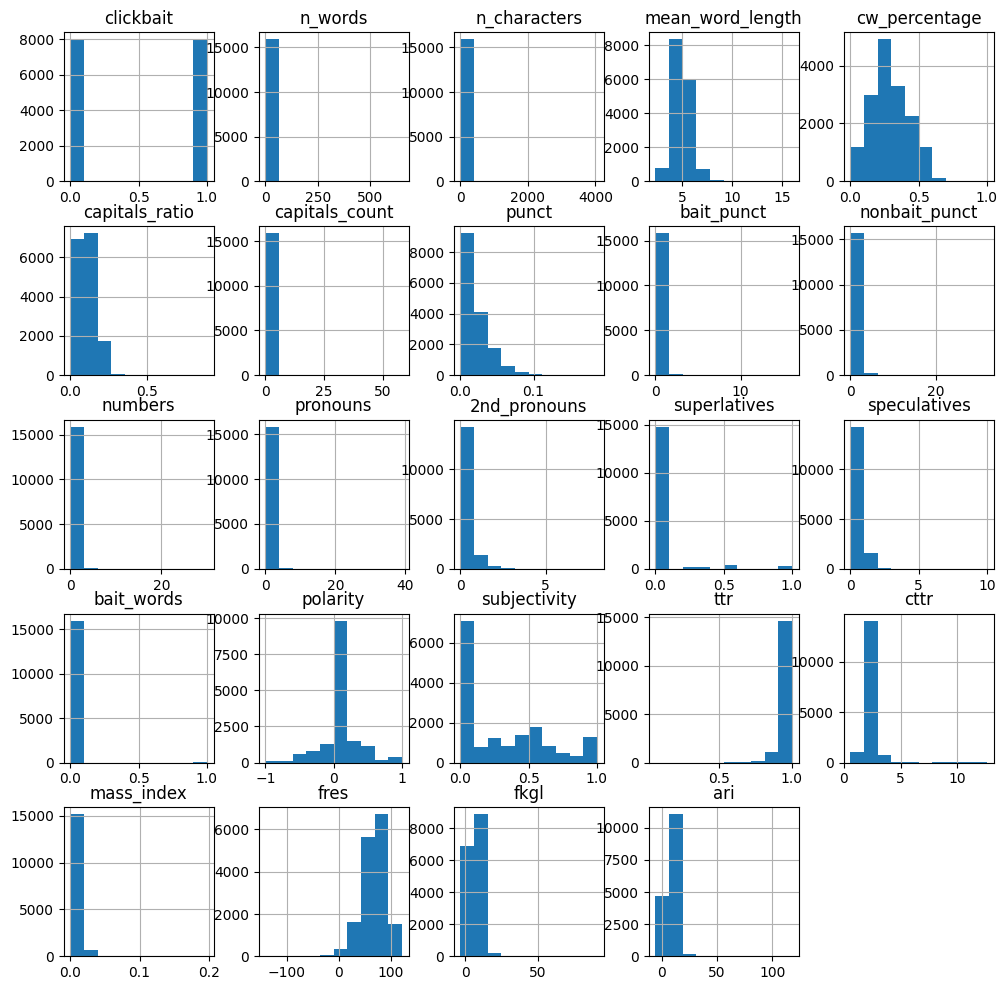

In [168]:
# check histograms
data_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Histograms for n_words and n_characters look bad. There are some outliers, possibly because of flaws in data scraping, for example:

In [169]:
# example of problematic title
long_titles = data_metrics[data_metrics['n_words'] > 100]
long_titles['title'].iloc[2]

"Sections Shows Live Yahoo!-ABC News Network | © 2017 ABC News Internet Ventures. All rights reserved. ABC News Homer and Marge to Separate on 'The Simpsons' The Reason Why Homer and Marge Will Split on 'The Simpsons' Priyanka Chopra on starring in the 'quintessential American dream' Gillian Anderson reveals long struggle with mental health issues Tensions reach all-time high on 'The Walking Dead' 'Jersey Shore' stars reunite for Sammi's 30th birthday party Slain singer Christina Grimmie's family remembers her on 23rd birthday Stanley Tucci on his 'Beauty and the Beast' character, new role in 'Feud' 'Arrow' star Colton Haynes is engaged to Jeff Leatham 'What's a yoot?' 'My Cousin Vinny' turns 25 Criss Angel speaks out after losing consciousness in failed stunt Nick Viall might be first Bachelor 'to be left at the end' Trump was talking about general surveillance in wiretapping claims, Spicer says GOP congressman defends racially charged tweet against critics States seeking Trump travel

In [170]:
# mean
print(f"mean number of words: {round(np.mean(data_metrics['n_words']), 1)}\n")
# percentiles
q_percentiles = [90, 99, 99.5, 99.7]
percentiles = np.percentile(data_metrics['n_words'], q_percentiles)
print(f"Percentiles:\nq: {q_percentiles}\n{percentiles}")

mean number of words: 12.6

Percentiles:
q: [90, 99, 99.5, 99.7]
[ 16.     30.     36.24  224.584]


In [171]:
# clickbait / non-clickbait ratio
long_titles = data_metrics[data_metrics['n_words'] > 40]
print("", long_titles['clickbait'].value_counts())

 clickbait
0    36
1    33
Name: count, dtype: int64


Looking at the percentiles we can safely delete all titles longer than 40 words, also the ratio of target variable won't be disturbed

In [172]:
# dropping outliers
shortened_metrics = data_metrics[data_metrics['n_words'] <= 40].copy()

array([[<Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>]], dtype=object)

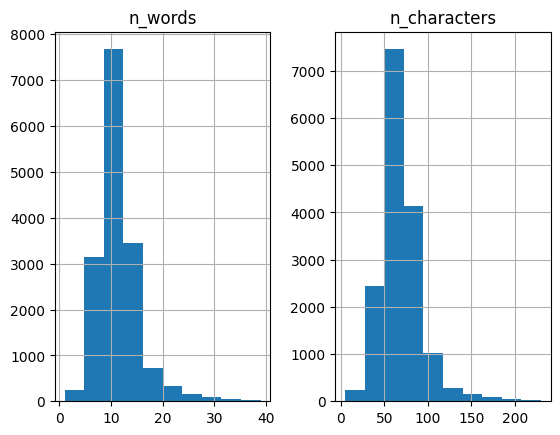

In [173]:
# check histograms again
shortened_metrics[['n_words', 'n_characters']].hist()

In [17]:
# lets check outliers for articles the same way

In [174]:
# apply metrics
name = 'n_words'
function = metrics_functions[name]
shortened_metrics[f"body_{name}"] = shortened_metrics['body'].apply(function)

<Axes: >

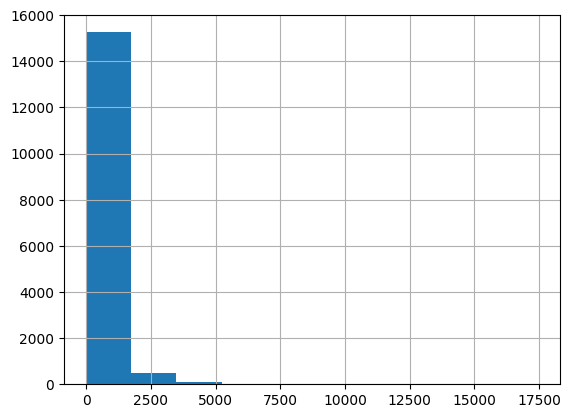

In [175]:
shortened_metrics['body_n_words'].hist()

In [176]:
len(shortened_metrics[shortened_metrics['body_n_words'] < 5000]) / len(shortened_metrics)

0.9964744396877361

In [177]:
final_data = shortened_metrics[shortened_metrics['body_n_words'] <= 5000].copy()

In [220]:
# apply metrics
for name, function in tqdm(metrics_functions.items()):
    if name not in ["n_words", "similarity"] :
        final_data[f"body_{name}"] = final_data['body'].apply(function)

 83%|████████▎ | 19/23 [19:43<02:55, 43.79s/it] /tmp/ipykernel_2909/4137713825.py:114: UserWarning: The text is 11 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_2909/4137713825.py:114: UserWarning: The text is 2 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_2909/4137713825.py:114: UserWarning: The text is 35 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_2909/4137713825.py:114: UserWarning: The text is 4 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_2909/4137713825.py:114: UserWarning: The text is 27 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_2909/4137713825.py:114: UserWarning: Th

In [226]:
name = 'similarity'
function = metrics_functions[name]
final_data[f"body_{name}"] = final_data.apply(lambda x: function(x['title'], x['body']), axis=1)

/home/tymek/projects/ClickbaitDetectionThesis/.venv/lib/python3.11/site-packages/scipy/spatial/distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


#### Overview

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

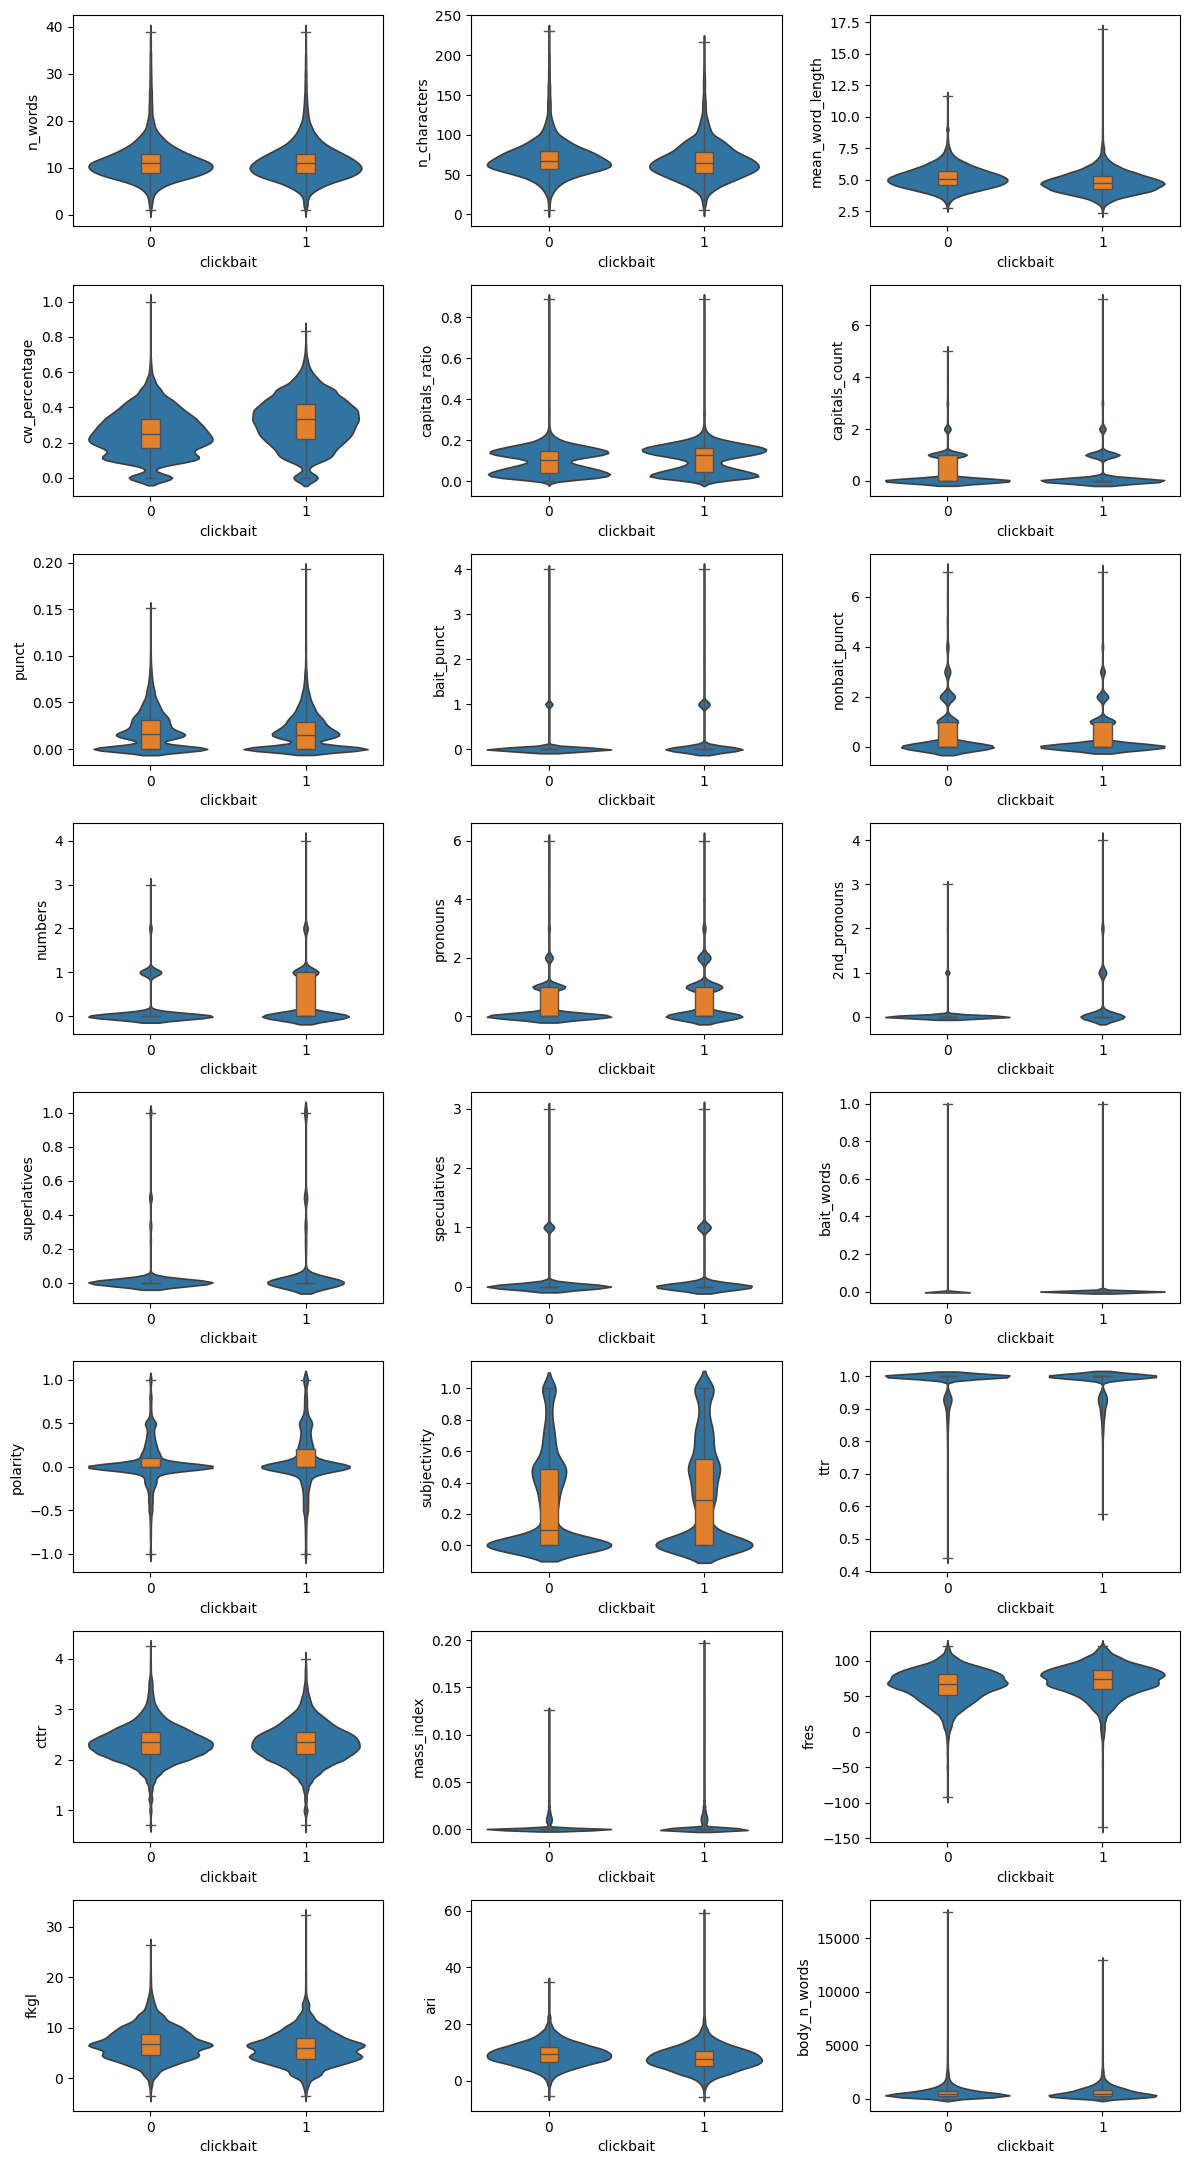

In [150]:
plt.figure(figsize=(12,24))
columns = final_data.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(9, 3, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=shortened_metrics, inner=None)
    sns.boxplot(x='clickbait', y=col, data=shortened_metrics, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

Half of the measures have almost identical characteristics for bait and non-bait. 

The only clear difference in median is in average percentage of common words, which is higher for clickbaits. There are also differences for other variables (capital letters, subjectivity, metrics measuring difficulty of the text) but they are rather not substantial

Many metrics have bigger standard deviation for clickbaits e.g., avg word length, punctuation usage, numbers or mass index.

Lets check violin plots for body:

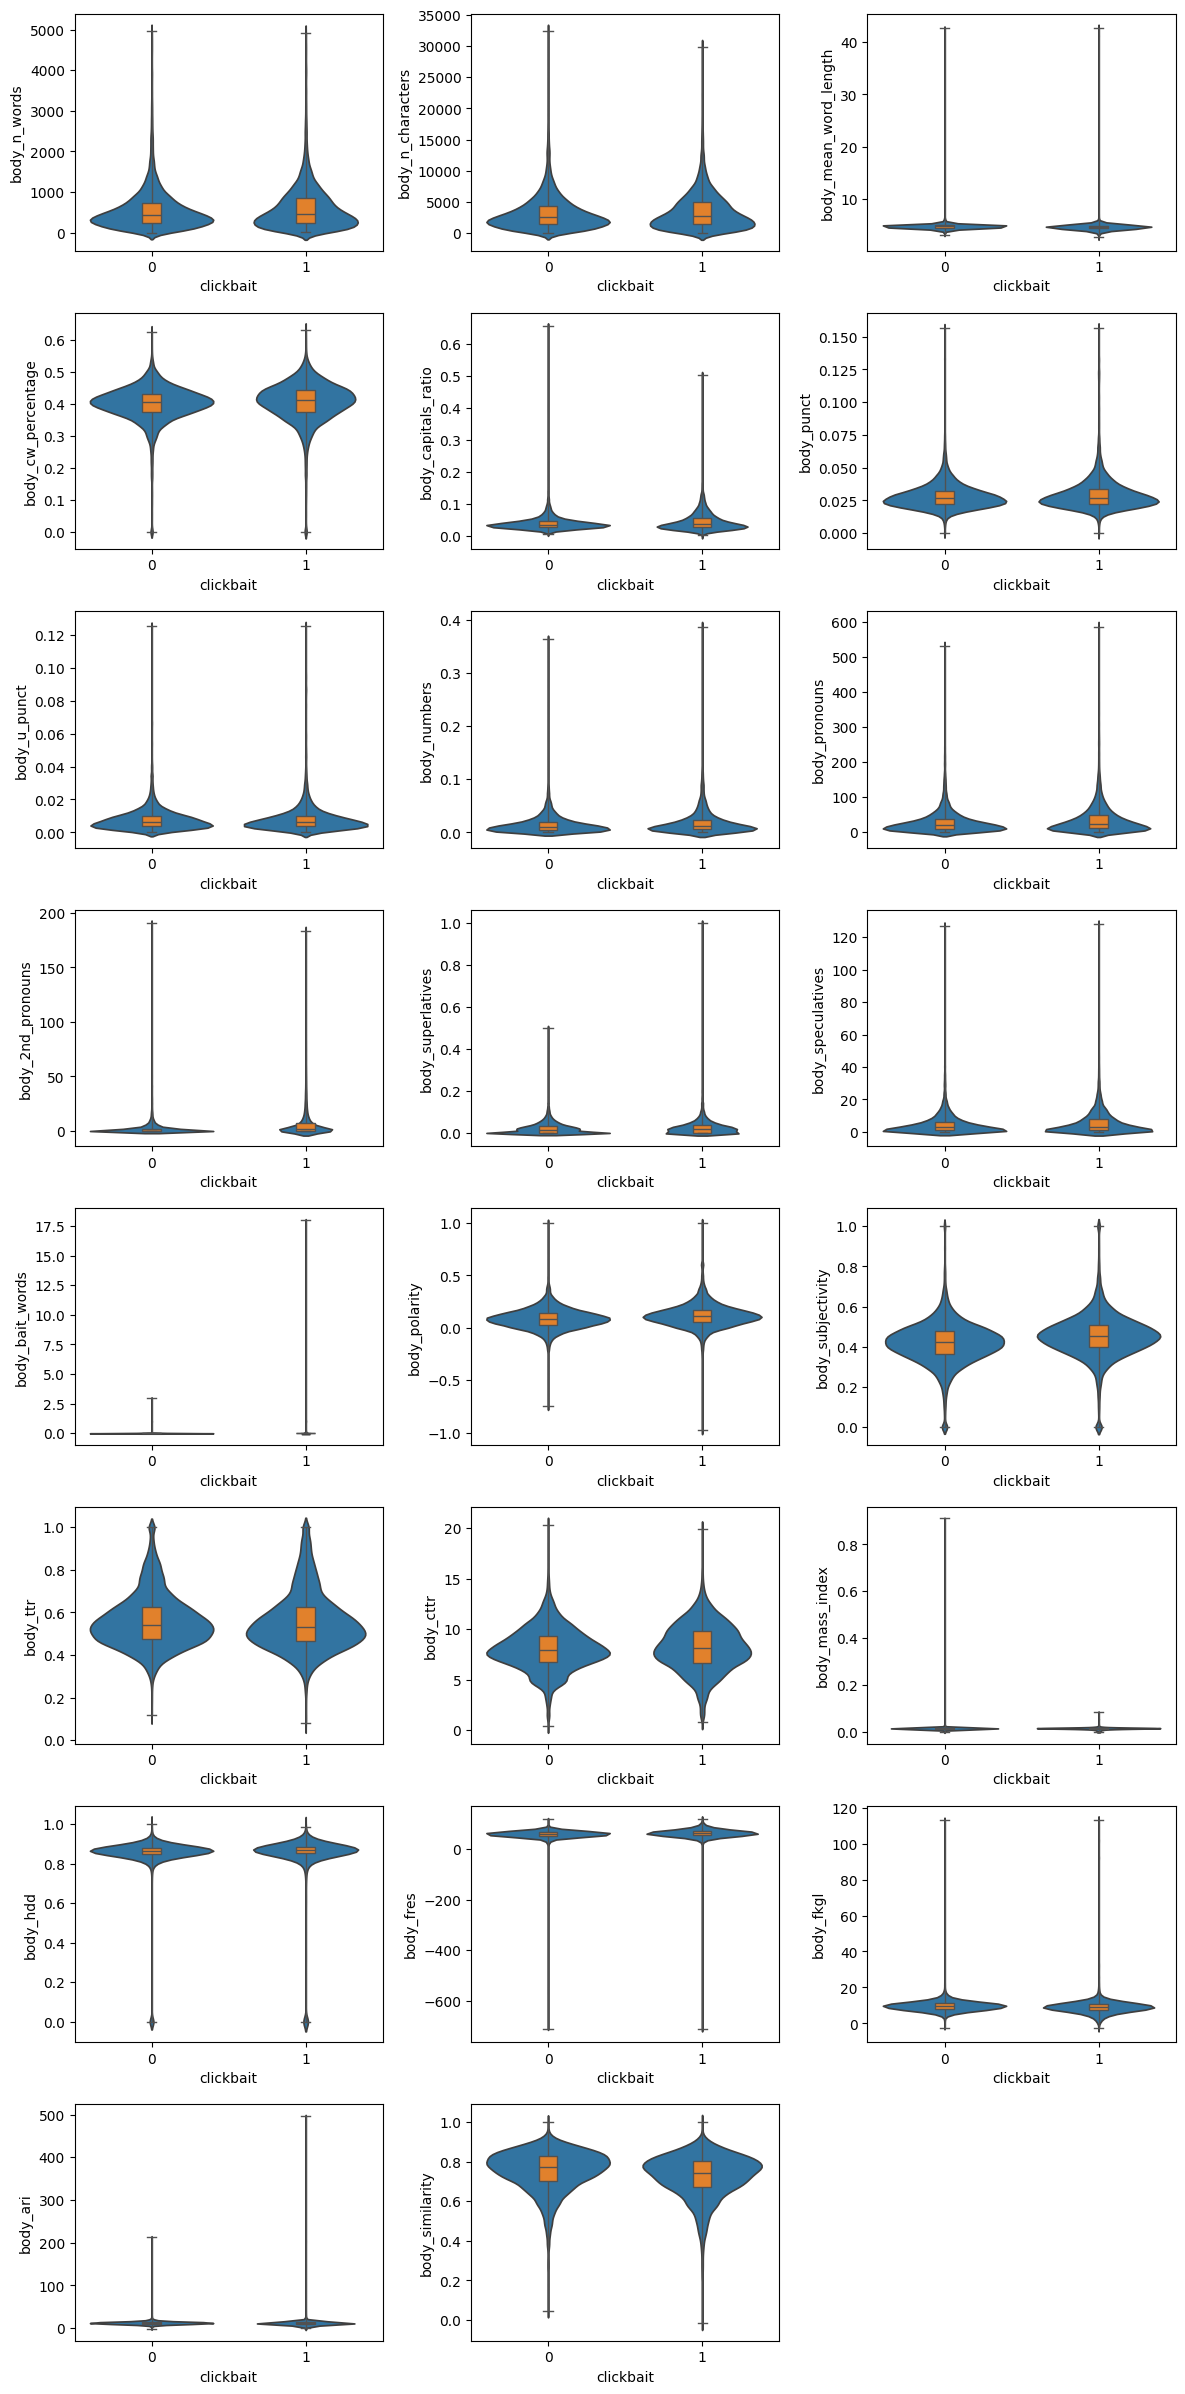

In [ ]:
plt.figure(figsize=(12,24))
columns = final_data.columns.to_list()[3:]
columns = [col for col in columns if col.startswith("body_")]
for i, col in enumerate(columns):
    plt.subplot(8, 3, i+1)
    ax = sns.violinplot(x='clickbait', y=col, data=final_data, inner=None)
    sns.boxplot(x='clickbait', y=col, data=final_data, width=0.12, whis=(0, 100), ax=ax)
plt.tight_layout()
plt.show()

#### Analysis

In [ ]:
def print_metrics(data, column, round_val=2):

    data_0 = data[data['clickbait'] == 0][column]
    data_1 = data[data['clickbait'] == 1][column]

    vals_0 = data_0.describe()
    vals_1 = data_1.describe()

    vals_0 = vals_0.apply(lambda x: round(x, round_val))
    vals_1 = vals_1.apply(lambda x: round(x, round_val))

    vals_0.drop(['count', '25%', '75%'], inplace=True)
    vals_1.drop(['count', '25%', '75%'], inplace=True)
    
    vals_0.at['ratio'] = ''
    vals_1.at['ratio'] = round(vals_1['mean'] / vals_0['mean'], round_val)

    vals_0.name = 'non clickbait'
    vals_1.name = 'clickbait'

    print(tabulate(pd.DataFrame([vals_0, vals_1]), headers=vals_1.index))

def plot_metrics(data, column):
    ax = sns.violinplot(x='clickbait', y=column, data=data, inner=None)
    sns.boxplot(x='clickbait', y=column, data=data, width=0.12, whis=(0, 100), ax=ax)

def print_merged(metric, on='title'):
    nonbait = " ".join(final_data[final_data['clickbait']==0][on].to_list())
    bait = " ".join(final_data[final_data['clickbait']==1][on].to_list())
    print(f"{metric.upper()}")
    print(f"non clickbait:  {round(metrics_functions[metric](nonbait), 3)}")
    print(f"clickbait:      {round(metrics_functions[metric](bait), 3)}")

##### Number of words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   11.45   4.19      1     11     39
clickbait       11.35   4.18      1     11     39  0.99


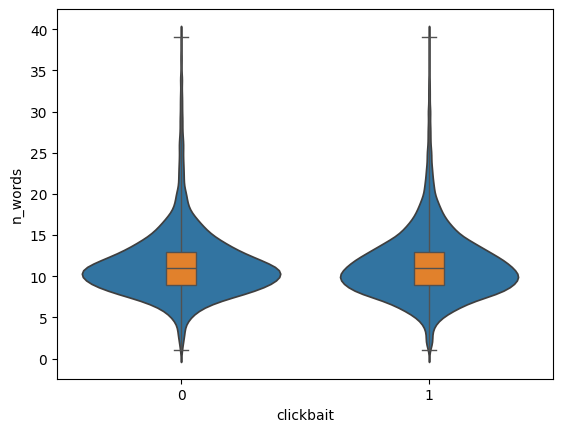

In [151]:
print_metrics(final_data, 'n_words')
plot_metrics(final_data, 'n_words')

In [93]:
# No difference at all for titles

##### Number of characters

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait   70.57  24.03      5     67    230
clickbait       67.08  24.28      6     64    217  0.95


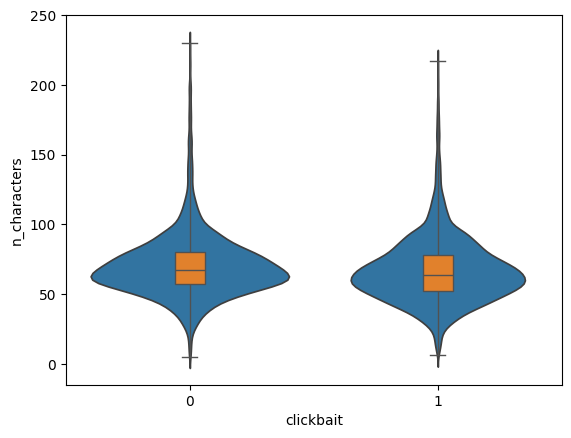

In [152]:
print_metrics(final_data, 'n_characters')
plot_metrics(final_data, 'n_characters')

In [ ]:
# same as before

##### Mean word length

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    5.15   0.88   2.75   5.08  11.67
clickbait        4.8    0.86   2.33   4.73  17     0.93


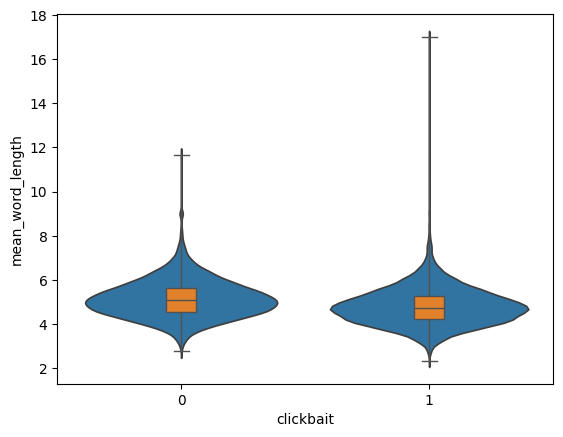

In [156]:
print_metrics(final_data, 'mean_word_length')
plot_metrics(final_data, 'mean_word_length')

In [172]:
# slightly shorter words on average for clickbaits

##### Common words percentage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.25   0.13      0   0.25   1
clickbait        0.32   0.14      0   0.33   0.83  1.28


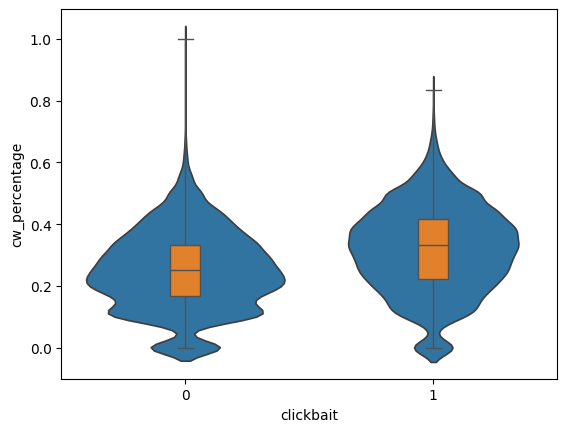

In [103]:
print_metrics(shortened_metrics, 'cw_percentage')
plot_metrics(shortened_metrics, 'cw_percentage')

In [104]:
# significant difference, clickbaits have more common words

##### Capital letters ratio

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.1    0.06      0   0.1    0.89
clickbait        0.11   0.07      0   0.13   0.89  1.1


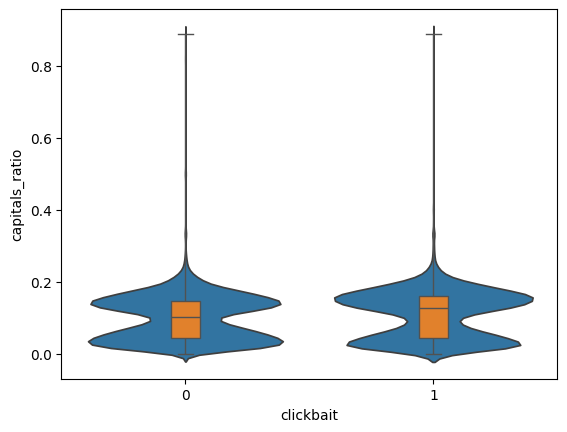

In [105]:
print_metrics(shortened_metrics, 'capitals_ratio')
plot_metrics(shortened_metrics, 'capitals_ratio')

In [177]:
# slightly bigger mean and median for clickbaits

##### Capital words

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.31   0.58      0      0      5
clickbait        0.3    0.6       0      0      7  0.97


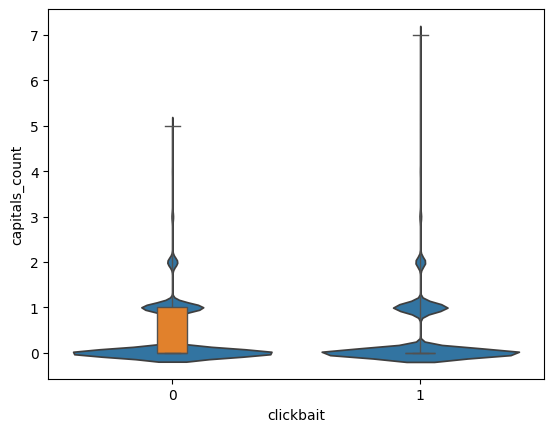

In [106]:
print_metrics(shortened_metrics, 'capitals_count')
plot_metrics(shortened_metrics, 'capitals_count')

In [107]:
# no difference

##### Punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.02   0.02      0   0.02   0.15
clickbait        0.02   0.02      0   0.02   0.19  1.0


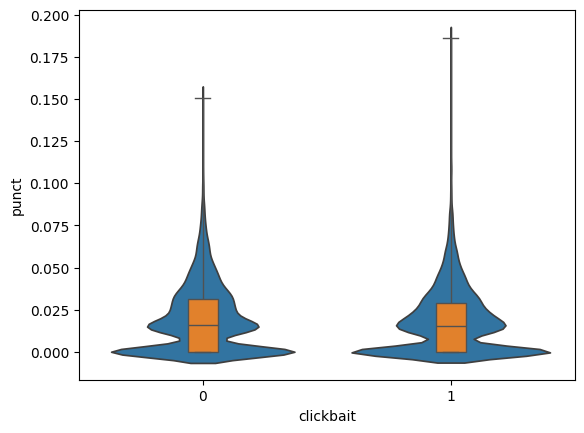

In [178]:
print_metrics(shortened_metrics, 'punct')
plot_metrics(shortened_metrics, 'punct')

In [109]:
# almost the same

##### Clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.06   0.26      0      0      4
clickbait        0.15   0.39      0      0      4  2.5


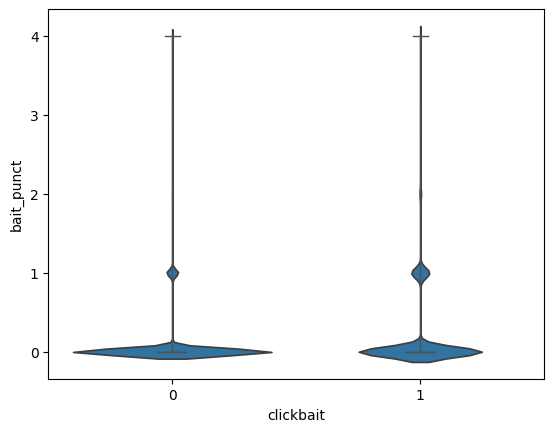

In [111]:
print_metrics(shortened_metrics, 'bait_punct')
plot_metrics(shortened_metrics, 'bait_punct')

In [112]:
# this feature was engineered based on eda, as we can see the mean count is way higher for clickbaits

##### Non clickbait punctuation

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.58   1.01      0      0      7
clickbait        0.4    0.81      0      0      7  0.69


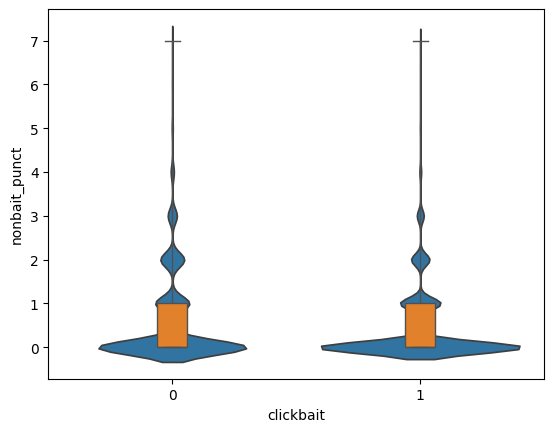

In [113]:
print_metrics(shortened_metrics, 'nonbait_punct')
plot_metrics(shortened_metrics, 'nonbait_punct')

In [114]:
# similar distribution, but mean count is higher for non clickbaits

##### Numbers usage

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.18   0.43      0      0      3
clickbait        0.3    0.55      0      0      4  1.67


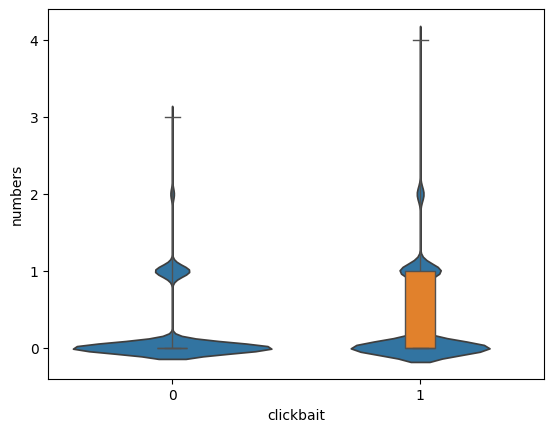

In [117]:
print_metrics(shortened_metrics, 'numbers')
plot_metrics(shortened_metrics, 'numbers')

In [118]:
# way more numbers used in clickbaits

##### Pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.33   0.64      0      0      6
clickbait        0.58   0.83      0      0      6  1.76


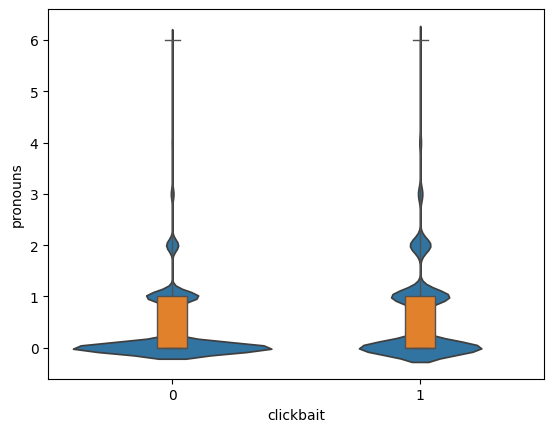

In [120]:
print_metrics(shortened_metrics, 'pronouns')
plot_metrics(shortened_metrics, 'pronouns')

In [121]:
# similar situation as before, median is 0 for both, but average usage is bigger for clickbaits

##### 2 person pronouns

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.04   0.21      0      0      3
clickbait        0.22   0.52      0      0      4  5.5


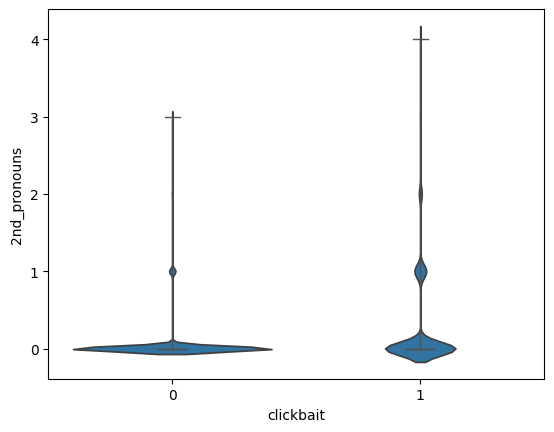

In [122]:
print_metrics(shortened_metrics, '2nd_pronouns')
plot_metrics(shortened_metrics, '2nd_pronouns')

In [ ]:
# here the difference is big, most non-bait titles do not use 2nd person pronouns

##### Superlatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.03   0.13      0      0      1
clickbait        0.06   0.19      0      0      1  2.0


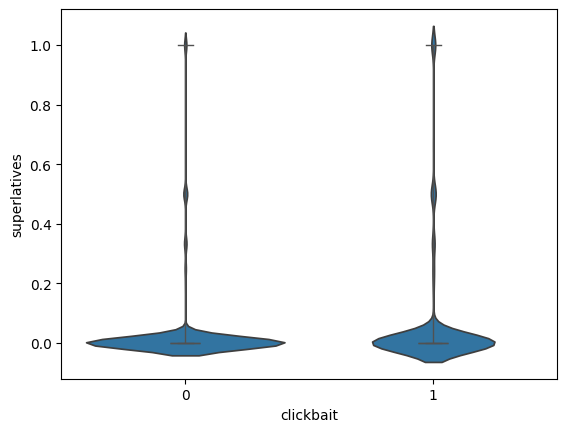

In [124]:
print_metrics(shortened_metrics, 'superlatives')
plot_metrics(shortened_metrics, 'superlatives')

In [125]:
# superlatives are used two times more in clickbaits, however they are still rare 

##### Speculatives

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.08   0.29      0      0      3
clickbait        0.13   0.35      0      0      3  1.62


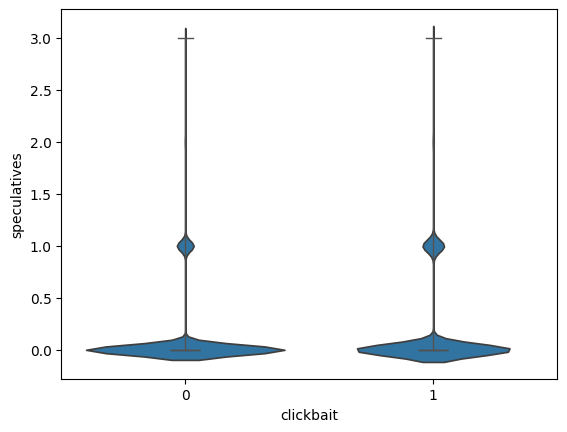

In [126]:
print_metrics(shortened_metrics, 'speculatives')
plot_metrics(shortened_metrics, 'speculatives')

In [128]:
# the same happens in here

##### Bait words

In [ ]:
# TODO

##### Polarity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.04   0.24     -1      0      1
clickbait        0.08   0.31     -1      0      1  2.0


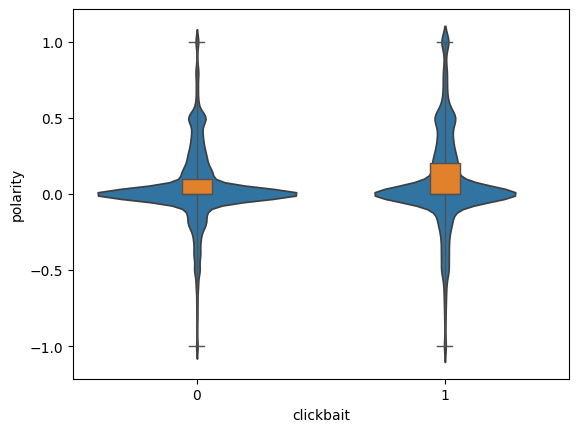

In [131]:
print_metrics(shortened_metrics, 'polarity')
plot_metrics(shortened_metrics, 'polarity')

In [ ]:
# polarity is bigger and more varied in clickbaits than in non clickbait headliens

##### Subjectivity

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.26   0.31      0   0.1       1
clickbait        0.32   0.33      0   0.29      1  1.23


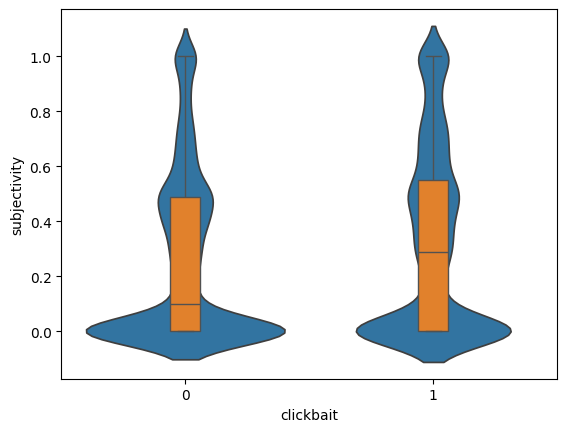

In [132]:
print_metrics(shortened_metrics, 'subjectivity')
plot_metrics(shortened_metrics, 'subjectivity')

In [ ]:
# clickbaits titles are more subjective. Both mean and median is bigger for clickbaits

##### TTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    0.98   0.04   0.44      1      1
clickbait        0.98   0.05   0.58      1      1  1.0


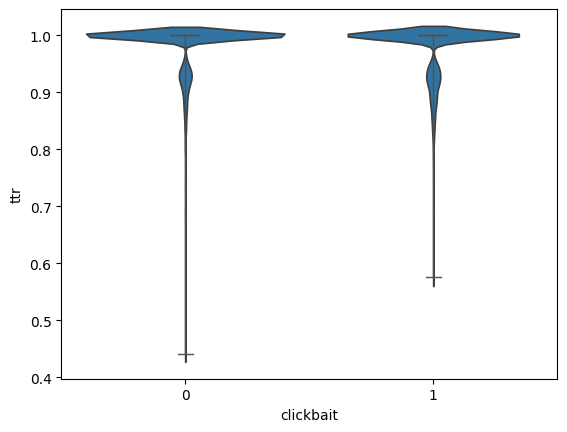

In [157]:
print_metrics(final_data, 'ttr')
plot_metrics(final_data, 'ttr')

In [199]:
# No difference at all, but its not strange as for most titles ttr will be 1, cause titles are so short its hard to not use all unique words
# lets check lexical diversity over all titles

In [202]:
print_merged('ttr')

TTR
non clickbait:  0.168
clickbait:      0.147


In [205]:
# clickbaits are less lexically diversed

##### CTTR

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    2.33   0.37   0.71   2.35   4.24
clickbait        2.32   0.39   0.71   2.35   4     1.0


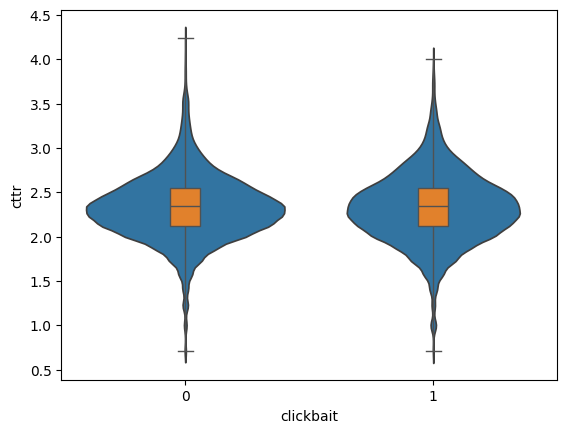

In [136]:
print_metrics(shortened_metrics, 'cttr')
plot_metrics(shortened_metrics, 'cttr')

In [137]:
# a little bigger standard deviation for cttr for clickbaits, other than that no differences

In [203]:
print_merged('cttr')

CTTR
non clickbait:  36.074
clickbait:      31.708


In [204]:
# again non clickbaits are more diversed

##### Maas index

/tmp/ipykernel_3018/1053143946.py:20: RuntimeWarning: invalid value encountered in scalar divide
  vals_1.at['ratio'] = round(vals_1['mean'] / vals_0['mean'], round_val)


                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait       0   0.01      0      0   0.13
clickbait           0   0.01      0      0   0.2   nan


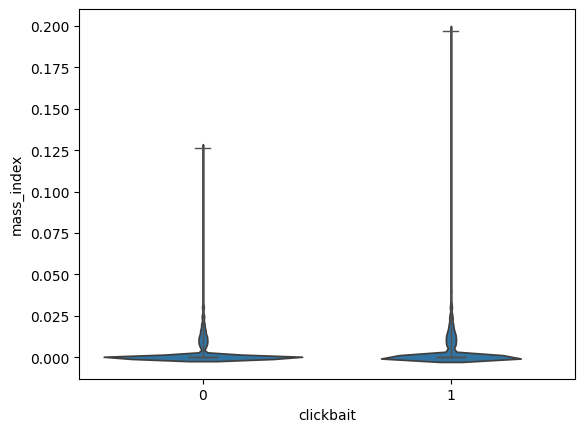

In [148]:
print_metrics(shortened_metrics, 'mass_index')
plot_metrics(shortened_metrics, 'mass_index')

In [206]:
# same issue as ttr

In [207]:
print_merged('mass_index')

MASS_INDEX
non clickbait:  0.014
clickbait:      0.015


In [208]:
# only small advantage for non clickbait headlines

##### FRES

                 mean    std     min    50%     max  ratio
-------------  ------  -----  ------  -----  ------  -------
non clickbait   65.02  22.97   -91.3  67.76  121.22
clickbait       71.67  22.21  -133.6  74.19  121.22  1.1


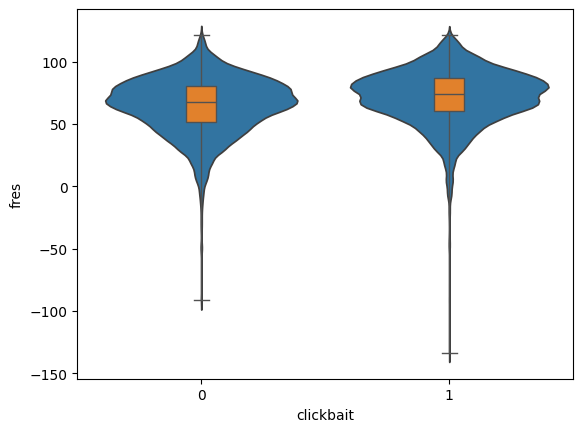

In [140]:
print_metrics(shortened_metrics, 'fres')
plot_metrics(shortened_metrics, 'fres')

In [141]:
# clickbaits headlines are easier to read

##### FKGL

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    6.93   3.32   -3.5    6.8   26.5
clickbait        5.95   3.25   -3.5    6     32.4  0.86


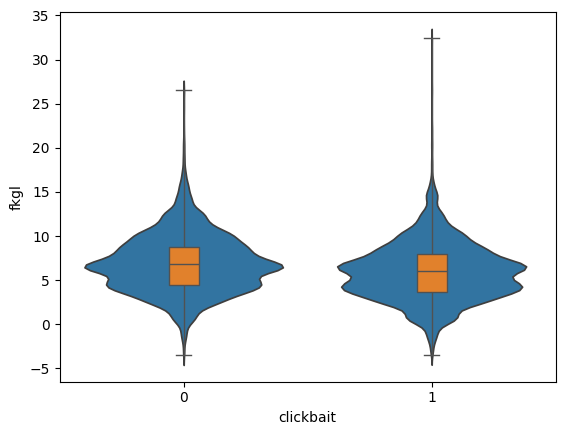

In [142]:
print_metrics(shortened_metrics, 'fkgl')
plot_metrics(shortened_metrics, 'fkgl')

In [143]:
# same results here, clickbait headlines are easier to read

##### ARI

                 mean    std    min    50%    max  ratio
-------------  ------  -----  -----  -----  -----  -------
non clickbait    9.43   3.98   -5.4    9.3   35
clickbait        7.99   4.13   -5.8    7.7   59.1  0.85


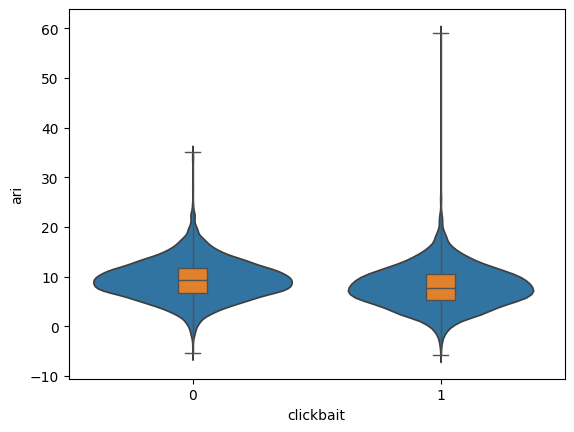

In [144]:
print_metrics(shortened_metrics, 'ari')
plot_metrics(shortened_metrics, 'ari')

In [ ]:
# distributions look similar to the fkgl

#### Summary

The differences are rather not substantial.

Clickbaits have smaller average word length (correlates with higher common words percentage), they are also easier to read. It is hard to calculate lexical diversity for titles, as they are super short. However, lexical diversity of all titles merged, is smaller for clickbaits. They are also more subjective.

Measures prepared specifically for clickbaits are all higher for clickbaits (pronouns, superlatives, speculatives). Also numbers usage is higher. 
Whats weird, there are no big differenes in capital letters usage.

Clickbaits often have higher standard deviation and more outliers.  

#### Fitting models:

Even if in the previous analysis for some features there were no differences between clickbaits and non-clickbaits, those features will still be included in the model building, as they may <i>interfere</i> with others.

<Axes: >

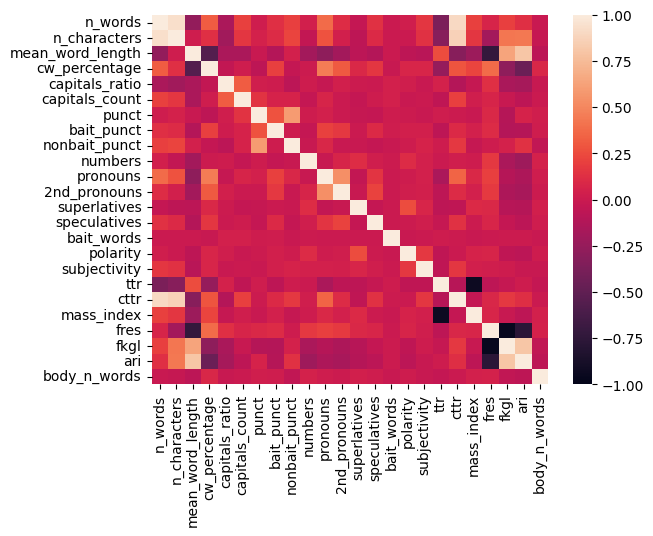

In [214]:
# check corelation
X = final_data.drop(['title', 'body', 'clickbait'], axis=1)
y = final_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1, annot_kws={'alpha': 0})

<Axes: >

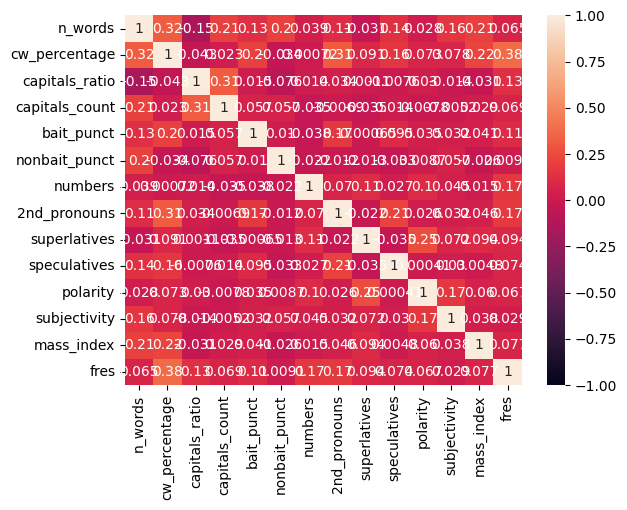

In [241]:
# dropping correlated columns:
# n_characters, mean_word_length, punctuation, ttr
train_columns = ['n_words', 'cw_percentage', 'capitals_ratio', 'capitals_count',  'bait_punct', 'nonbait_punct', 'numbers', '2nd_pronouns', 'superlatives', 'speculatives', 'polarity', 'subjectivity', 'mass_index', 'fres']
X = final_data[train_columns]
y = final_data['clickbait']

X_test = test_data[train_columns]
y_test = test_data['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [242]:
# split and prepare data
X_train = X
y_train = y

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [243]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.618236
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15828
Model:                          Logit   Df Residuals:                    15814
Method:                           MLE   Df Model:                           13
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1081
Time:                        15:09:26   Log-Likelihood:                -9785.4
converged:                       True   LL-Null:                       -10971.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.2273      0.021    -11.070      0.000      -0.267      -0.187
cw_percentage    

In [248]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.46 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2006
           1       0.64      0.64      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.65      0.64      0.64      3989
weighted avg       0.65      0.65      0.65      3989



Lets drop insignificant variables and fit the model again

In [263]:
cols_to_drop = ['capitals_count', 'speculatives', 'polarity']
X_train = X.drop(cols_to_drop, axis=1)
X_test2 = X_test.drop(cols_to_drop, axis=1)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test2)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.618325
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                15828
Model:                          Logit   Df Residuals:                    15817
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Nov 2024   Pseudo R-squ.:                  0.1079
Time:                        15:12:38   Log-Likelihood:                -9786.9
converged:                       True   LL-Null:                       -10971.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
n_words           -0.2330      0.020    -11.777      0.000      -0.272      -0.194
cw_percentage    

In [264]:
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.46 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2006
           1       0.65      0.64      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.65      0.65      0.65      3989
weighted avg       0.65      0.65      0.65      3989



<!-- We got better accuracy, but it's impossible to build a good model based only of informativeness measures of title. Also, many of them are correlated, so its enough to choose only some of them (eg n_words, fkgl, cw_percentage). 

Conclusions from the model - headlines which are easier to read (fkgl), contain less words, but have higher common words percentage are more likely to be classified as clickbait.

 -->
Almost identical, but slightly better perormance.<br>
All coeficients correspond to the analysis.

For the sake of testing, lets put all the variables to random forest:

In [299]:
X_train = final_data.drop(['title', 'body', 'clickbait', 'body_n_words'], axis=1)
y_train = final_data['clickbait']

X_test = test_data.drop(['title', 'body', 'clickbait'], axis=1)
y_test = test_data['clickbait']

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2006
           1       0.66      0.63      0.64      1983

    accuracy                           0.65      3989
   macro avg       0.66      0.65      0.65      3989
weighted avg       0.66      0.65      0.65      3989



lets add a little bit of fine tuning including dropping correlated columns, setting max depth to prevent overfitting

In [337]:
rf = RandomForestClassifier(n_estimators=120, max_depth=15)
rf.fit(X_train[train_columns], y_train)

threshold = 0.47
predicted_proba = rf.predict_proba(X_test[train_columns])
preds = (predicted_proba [:,1] >= threshold).astype('int')

# preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      2006
           1       0.68      0.67      0.67      1983

    accuracy                           0.68      3989
   macro avg       0.68      0.68      0.68      3989
weighted avg       0.68      0.68      0.68      3989



In [338]:
pd.DataFrame(data={'feature': rf.feature_names_in_, 'importance': rf.feature_importances_}, columns=['feature', 'importance']).sort_values('importance', ascending=False)

,feature,importance
1,cw_percentage,0.165545
2,capitals_ratio,0.153074
13,fres,0.121995
0,n_words,0.092916
10,polarity,0.087973
11,subjectivity,0.084912
7,2nd_pronouns,0.077474
5,nonbait_punct,0.047321
12,mass_index,0.042527
6,numbers,0.034356


### Body analysis

In [11]:
body_metrics = data.copy()

In [12]:
# apply metrics
for name, function in metrics_functions.items():
    body_metrics[name] = body_metrics['body'].apply(function)

/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 11 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 3 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 35 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 4 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 27 words long. HD-D metric is not defined for texts with less than 42 tokens.
  warnings.warn(message, UserWarning)
/tmp/ipykernel_912/2894274460.py:33: UserWarning: The text is 40 words long. HD-D metric is not defined for text

array([[<Axes: title={'center': 'clickbait'}>,
        <Axes: title={'center': 'n_words'}>,
        <Axes: title={'center': 'n_characters'}>],
       [<Axes: title={'center': 'cw_percentage'}>,
        <Axes: title={'center': 'ttr'}>,
        <Axes: title={'center': 'cttr'}>],
       [<Axes: title={'center': 'hdd'}>,
        <Axes: title={'center': 'fres'}>,
        <Axes: title={'center': 'fkgl'}>],
       [<Axes: title={'center': 'ari'}>, <Axes: >, <Axes: >]],
      dtype=object)

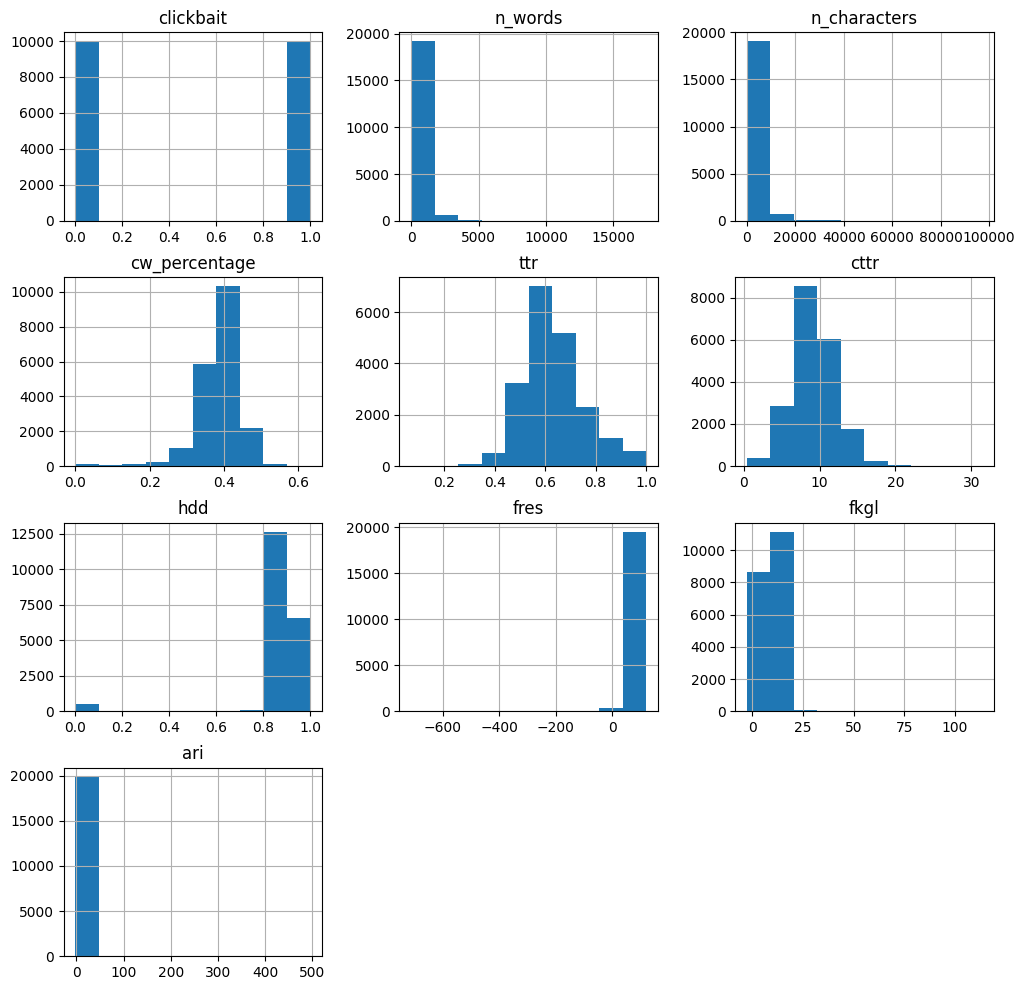

In [50]:
# check histograms
body_metrics.drop(['title', 'body'], axis=1).hist(figsize=(12,12))

Now let's plot boxplots, as there we can find insights of the relationships of each variable with target var

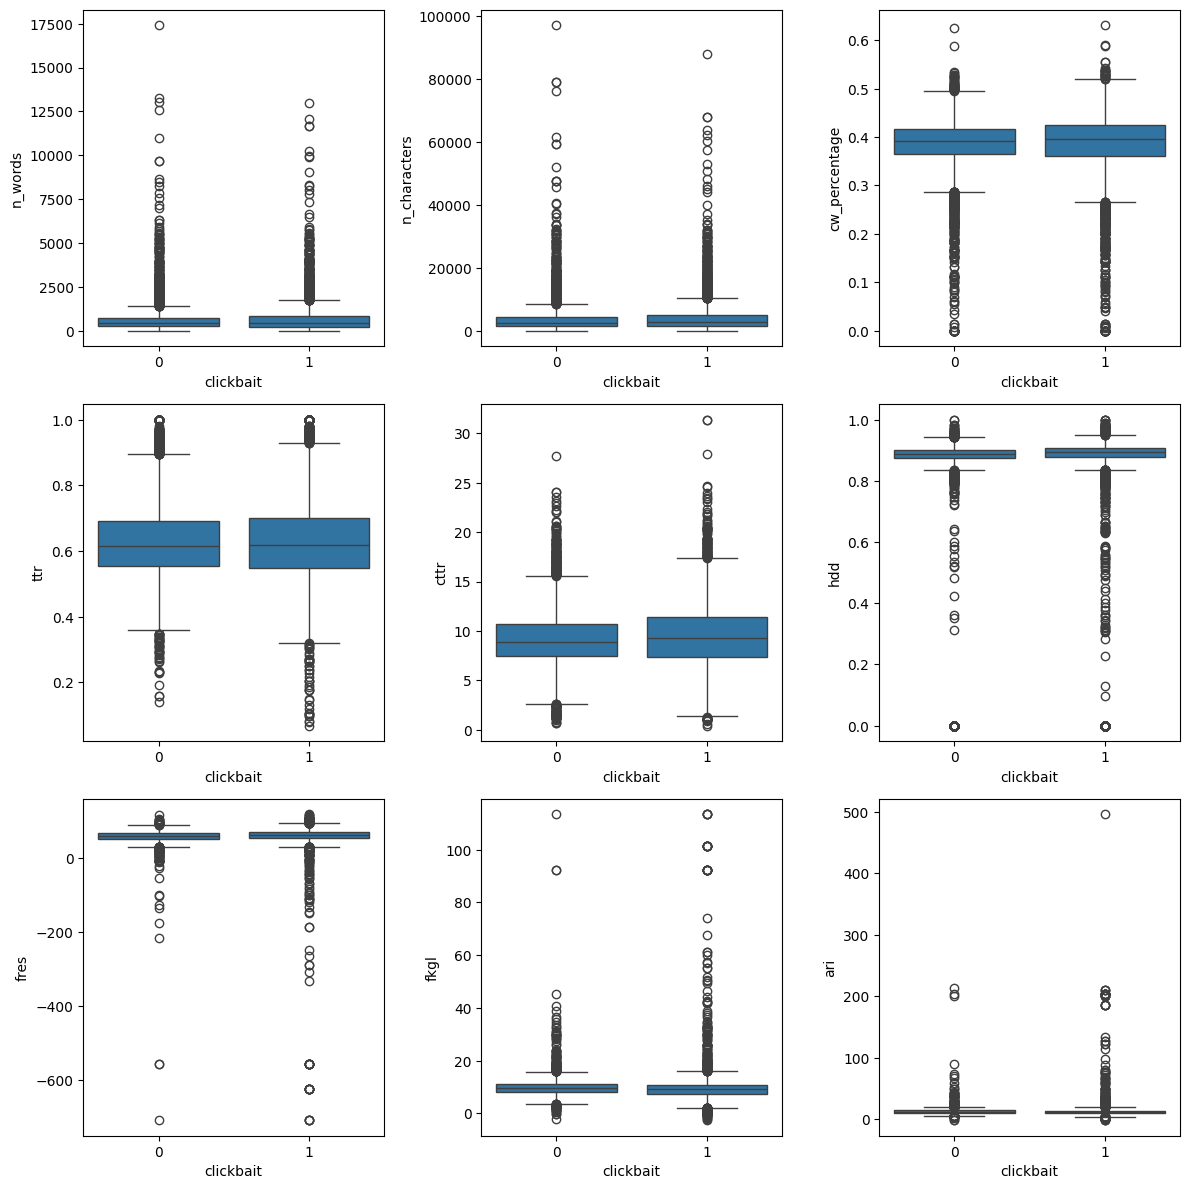

In [51]:
plt.figure(figsize=(12,12))
columns = body_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='clickbait', y=col, data=body_metrics)
plt.tight_layout()
plt.show()

Due to some outliers, its hard to see the relationships. Lets print some numerical metrics

In [52]:
def calculate_stats(series: pd.Series):
    stats_data = {
'mean': series.mean(),
'median': series.median(),
'q1': series.quantile(0.25),
'q3': series.quantile(0.75),
'std': series.std()
    }
    return pd.DataFrame(stats_data)
    
columns = body_metrics.columns.to_list()[3:]
for i, col in enumerate(columns):
    print(f"\n-----\n{col.upper()}")
    stats = calculate_stats(body_metrics.groupby('clickbait')[col])
    print(stats)



-----
N_WORDS
                 mean  median     q1     q3         std
clickbait                                              
0          586.317339   428.0  249.0  723.5  675.872227
1          633.739331   468.0  237.0  844.0  687.075970

-----
N_CHARACTERS
                  mean  median      q1      q3          std
clickbait                                                  
0          3515.115396  2580.0  1487.0  4352.0  3984.775383
1          3764.405663  2781.0  1405.0  5010.0  4058.578888

-----
CW_PERCENTAGE
               mean    median        q1        q3       std
clickbait                                                  
0          0.385966  0.391844  0.364511  0.416792  0.054047
1          0.388254  0.395381  0.361139  0.424869  0.061477

-----
TTR
               mean    median        q1        q3       std
clickbait                                                  
0          0.630099  0.615079  0.554392  0.690476  0.113783
1          0.633000  0.617155  0.548706  0.701276

Generally all stats look quite similar. The only clear pattern is that the standard deviation (across all measures) is bigger for clickabaits.

Fitting models:

<Axes: >

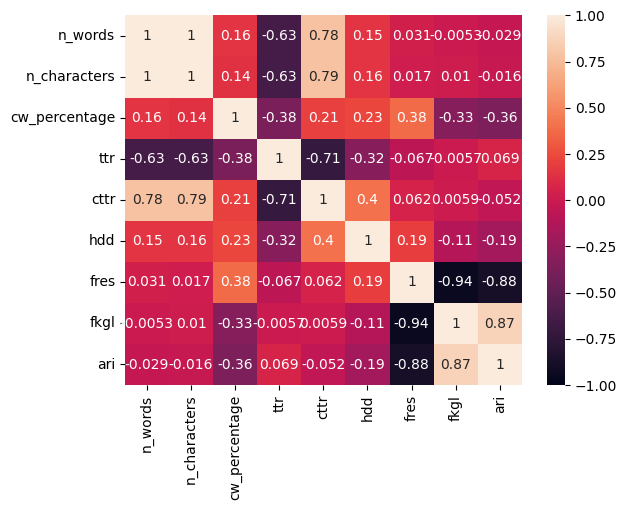

In [53]:
# check corelation
X = body_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = body_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

<Axes: >

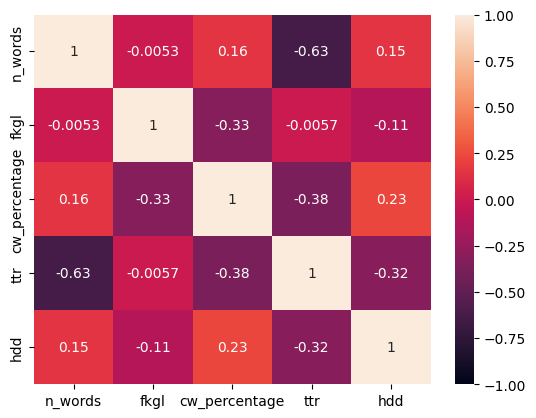

In [54]:
# dropping correlated columns 'n_characters', 'cttr', 'fres', 'ari'
X = body_metrics[['n_words', 'fkgl', 'cw_percentage', 'ttr', 'hdd']]
y = body_metrics['clickbait']

sns.heatmap(X.corr(), annot=True, vmax=1, vmin=-1)

In [55]:
# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

In [56]:
# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.689836
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14951
Method:                           MLE   Df Model:                            4
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                0.004777
Time:                        19:58:44   Log-Likelihood:                -10317.
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                 1.571e-20
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words           0.1307      0.024      5.494      0.000       0.084       0.177
fkgl             -0.

In [57]:
# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.56      0.61      0.58      2509
           1       0.56      0.51      0.53      2477

    accuracy                           0.56      4986
   macro avg       0.56      0.56      0.56      4986
weighted avg       0.56      0.56      0.56      4986



There is also big corelation between only n_words and ttr, so lets drop one and fit a model again

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['ttr'], axis=1), y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.690829
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14952
Method:                           MLE   Df Model:                            3
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                0.003344
Time:                        19:59:02   Log-Likelihood:                -10332.
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                 5.927e-15
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
n_words           0.0507      0.017      2.956      0.003       0.017       0.084
fkgl             -0.

Again we got better accuracy after dropping ttr, but still information measures are not good enough to build a proper model.

Lets try to fit random forest with all the variables:

In [60]:
X = body_metrics.drop(['title', 'body', 'clickbait'], axis=1)
y = body_metrics['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      2509
           1       0.61      0.59      0.60      2477

    accuracy                           0.61      4986
   macro avg       0.61      0.61      0.61      4986
weighted avg       0.61      0.61      0.61      4986



### Combined

In [13]:
# prepare body data
body_dropped = body_metrics.drop(['title', 'body'], axis=1)
body_dropped.columns = ['body_' + col if col != 'clickbait' else col for col in body_dropped.columns]

In [14]:
# prepare title data
title_dropped = data_metrics.drop(['title', 'body', 'clickbait'], axis=1)
title_dropped.columns = ['title_' + col for col in title_dropped.columns]

In [15]:
all_data = pd.concat([body_dropped, title_dropped], axis=1)

In [23]:
X = all_data.drop(['clickbait', 'body_cw_percentage', 'body_fres', 'title_n_characters', 'body_n_characters', 'title_fres', 'title_ari', 'body_hdd'], axis=1)
y = all_data['clickbait']

# split and prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
y_train = y_train.reset_index(drop=True)

# fit the model
log_reg = sm.Logit(y_train, X_train_scaled).fit()
print(log_reg.summary())

# make predictions
probs = log_reg.predict(X_test_scaled)
preds = [1 if prob > 0.5 else 0 for prob in probs]
print(classification_report(y_test, preds))

Optimization terminated successfully.
         Current function value: 0.649865
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              clickbait   No. Observations:                14956
Model:                          Logit   Df Residuals:                    14946
Method:                           MLE   Df Model:                            9
Date:                Fri, 11 Oct 2024   Pseudo R-squ.:                 0.06244
Time:                        21:56:35   Log-Likelihood:                -9719.4
converged:                       True   LL-Null:                       -10367.
Covariance Type:            nonrobust   LLR p-value:                4.389e-273
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
body_n_words           -0.0647      0.029     -2.204      0.027      -0.122      -0.007
bo

In [32]:
X = all_data.drop(['clickbait', 'body_n_characters', 'body_cttr', 'body_fres', 'title_n_characters', 'title_cttr', 'title_fres', 'title_ari'], axis=1)
y = all_data['clickbait']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65      2509
           1       0.65      0.65      0.65      2477

    accuracy                           0.65      4986
   macro avg       0.65      0.65      0.65      4986
weighted avg       0.65      0.65      0.65      4986



Not something we were hoping for...

In [ ]:
## Measure

In [ ]:
"""
lexical
sqrt capitals
sqrt common words 

average of usages 
2nd person pronoun - yes / no
superlatives - yes / no
bait vocabulary - yes / no
special punctuation - yes / no
only capital letters word
number 

similarity
squared?

sentiment
sqrt() for each and then multiply
"""